# 농산물 가격 및 기상 데이터 분석 및 시각화

## 1. 라이브러리 임포트

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # 스케일링을 위해 추가

# 한글 폰트 설정 (Windows 환경)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False # 마이너스 폰트 깨짐 방지

## 2. 데이터 로드 및 초기 탐색

In [31]:
# 파일 경로
price_file = './data/region_price.xlsx'
weather_file = './data/region_weather.csv'
cold_file = './data/mon_cold.xlsx'
hot_file = './data/mon_hot.xlsx'
wind_file = './data/mon_wind.xlsx'

# 데이터 로드
df_price = pd.read_excel(price_file)
df_weather = pd.read_csv(weather_file)
df_cold = pd.read_excel(cold_file)
df_hot = pd.read_excel(hot_file)
df_wind = pd.read_excel(wind_file)


# 각 데이터프레임 확인
print("\n--- 가격 데이터 (df_price) ---")
print(df_price.head(2))
print("\n--- 날씨 데이터 (df_weather) ---")
print(df_weather.head(2))
print("\n--- 한파 데이터 (df_cold) ---")
print(df_cold.head(2))
print("\n--- 폭염 데이터 (df_hot) ---")
print(df_hot.head(2))
print("\n--- 태풍 데이터 (df_wind) ---")
print(df_wind.head(2))


--- 가격 데이터 (df_price) ---
    지역       날짜  품목          평균가격      총거래물량
0  강원도  2021-01  감자  24245.289659  3012880.0
1  경기도  2021-01  감자  24006.188904   356360.0

--- 날씨 데이터 (df_weather) ---
    지역       날짜  평균기온(°C)  월합강수량(00~24h만)(mm)  평균풍속(m/s)  최심적설(cm)
0  강원도  2019-01 -1.857143            4.678571   1.714286      17.1
1  강원도  2019-02  0.585714           22.928571   1.614286      17.1

--- 한파 데이터 (df_cold) ---
    지역  2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  2021-11  \
0  경기도        0        1        1        0        0        0        0   
1  강원도        0        1        1        1        0        0        0   

   2021-12  2022-01  ...  2023-12  2024-01  2024-02  2024-03  2024-04  \
0        1        1  ...        1        1        0        0        0   
1        1        1  ...        1        1        0        0        0   

   2024-11  2024-12  2025-01  2025-02  2025-03  
0        0        0        1        1        0  
1        0        1        1        1       

## 3. 데이터 전처리

In [32]:
# 날짜 컬럼을 datetime 형식으로 변환
df_price["날짜"] = pd.to_datetime(df_price["날짜"])
df_weather["날짜"] = pd.to_datetime(df_weather["날짜"])

# 가격 데이터의 "평균가격"과 "총거래물량" 컬럼을 숫자형으로 변환
df_price["평균가격"] = pd.to_numeric(df_price["평균가격"], errors="coerce")
df_price["총거래물량"] = pd.to_numeric(df_price["총거래물량"], errors="coerce")

# 날씨 데이터 컬럼명 정리
weather_cols = ["지역", "날짜", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]

def preprocess_event_df(df, event_name):
    # 첫 번째 컬럼을 "지역"으로 설정하고 나머지 컬럼은 날짜로 간주
    df_melted = df.melt(id_vars=[df.columns[0]], var_name="날짜", value_name=f"{event_name}_발생")
    df_melted.rename(columns={df.columns[0]: "지역"}, inplace=True)
    # YYYY-MM 형식의 날짜를 datetime으로 변환 후 월 단위로 통일
    df_melted["날짜"] = pd.to_datetime(df_melted["날짜"], format="%Y-%m")
    df_melted["날짜"] = df_melted["날짜"] .dt.to_period('M')
    return df_melted

df_cold_processed = preprocess_event_df(df_cold, "한파")
df_hot_processed = preprocess_event_df(df_hot, "폭염")
df_wind_processed = preprocess_event_df(df_wind, "태풍")

print("\n--- 전처리된 한파 데이터 (df_cold_processed) ---")
print(df_cold_processed.head())
print("\n--- 전처리된 폭염 데이터 (df_hot_processed) ---")
print(df_hot_processed.head())
print("\n--- 전처리된 태풍 데이터 (df_wind_processed) ---")
print(df_wind_processed.head())


--- 전처리된 한파 데이터 (df_cold_processed) ---
     지역       날짜  한파_발생
0   경기도  2020-11      0
1   강원도  2020-11      0
2  전라남도  2020-11      0
3  경상남도  2020-11      0
4  경상북도  2020-11      0

--- 전처리된 폭염 데이터 (df_hot_processed) ---
     지역       날짜  폭염_발생
0   경기도  2020-06      1
1   강원도  2020-06      1
2  전라남도  2020-06      1
3  경상남도  2020-06      1
4  경상북도  2020-06      1

--- 전처리된 태풍 데이터 (df_wind_processed) ---
        지역       날짜  태풍_발생
0  제주특별자치도  2020-08      1
1      강원도  2020-08      1
2     전라남도  2020-08      1
3     경상남도  2020-08      1
4    광주광역시  2020-08      1


## 4. 가격 및 날씨 데이터 통합

In [33]:
# 날짜 월 단위 통일
df_weather["날짜"] = df_weather["날짜"].dt.to_period('M')

# 날짜 월 단위 통일
df_price["날짜"] = df_price["날짜"].dt.to_period('M')

# 가격 데이터와 날씨 데이터를 병합
merged_df = pd.merge(df_price, df_weather, left_on=["지역", "날짜"], right_on=["지역", "날짜"], how="left")

# 이벤트 데이터 병합
merged_df = pd.merge(merged_df, df_cold_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_hot_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_wind_processed, on=["지역", "날짜"], how="left")

# 최심적설, 한파, 폭염, 태풍의 NaN 값은 0으로 fill
merged_df["최심적설(cm)"] = merged_df["최심적설(cm)"].fillna(0)
merged_df["한파_발생"] = merged_df["한파_발생"].fillna(0)
merged_df["폭염_발생"] = merged_df["폭염_발생"].fillna(0)
merged_df["태풍_발생"] = merged_df["태풍_발생"].fillna(0)

# 숫자형 재변환하고, 변환할 수 없는 행 제거
numeric_cols = ["평균가격", "총거래물량", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
merged_df.dropna(subset=numeric_cols, inplace=True)

print("병합된 데이터")
merged_df

병합된 데이터


,지역,날짜,품목,평균가격,총거래물량,평균기온(°C),월합강수량(00~24h만)(mm),평균풍속(m/s),최심적설(cm),한파_발생,폭염_발생,태풍_발생
0,강원도,2021-01,감자,24245.289659,3012880.0,-3.435714,10.221429,1.778571,4.9,1.0,0.0,0.0
1,경기도,2021-01,감자,24006.188904,356360.0,-3.680000,18.460000,1.440000,9.4,1.0,0.0,0.0
2,제주특별자치도,2021-01,감자,37886.008230,330480.0,6.700000,84.225000,4.575000,9.2,0.0,0.0,0.0
3,경상남도,2021-01,감자,27559.604013,533300.0,1.192857,17.678571,1.700000,0.0,1.0,0.0,0.0
4,경상북도,2021-01,감자,24701.552614,462160.0,-1.421429,12.728571,2.350000,0.9,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8972,대전광역시,2025-06,파프리카,16243.935018,2010.0,24.000000,300.100000,1.700000,0.0,0.0,1.0,0.0
8973,대구광역시,2025-06,파프리카,15602.542683,1360.0,24.800000,163.700000,1.800000,0.0,0.0,1.0,0.0
8974,경상북도,2025-06,파프리카,17073.033708,890.0,23.271429,177.642857,1.621429,0.0,0.0,1.0,0.0
8975,광주광역시,2025-06,파프리카,12027.783188,1445.0,24.000000,246.400000,1.600000,0.0,0.0,1.0,0.0


## 5. 이상치 탐지 및 제거 (평균가격, 총거래물량)

In [34]:
def remove_outliers_iqr(df, column):
    # 결측값은 먼저 제거
    df = df[df[column].notna()]

    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ["평균가격", "총거래물량"]
original_rows = len(merged_df)

# 1. 결측값 제거 후 이상치 제거
if "평균가격" in merged_df.columns:
    merged_df = merged_df[merged_df["평균가격"].notna()]
    merged_df = remove_outliers_iqr(merged_df, "평균가격")
    print(f"컬럼 평균가격에서 이상치 제거 후 데이터 크기: {len(merged_df)}")

# 2. 결측값 평균으로 대체
if "총거래물량" in merged_df.columns:
    mean_value = merged_df["총거래물량"].mean()
    merged_df["총거래물량"].fillna(mean_value, inplace=True)

print(f"\n총 {original_rows - len(merged_df)}개 행 제거")
merged_df.info()

컬럼 평균가격에서 이상치 제거 후 데이터 크기: 8513

총 25개 행 제거
<class 'pandas.core.frame.DataFrame'>
Index: 8513 entries, 0 to 8976
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   지역                  8513 non-null   object   
 1   날짜                  8513 non-null   period[M]
 2   품목                  8513 non-null   object   
 3   평균가격                8513 non-null   float64  
 4   총거래물량               8513 non-null   float64  
 5   평균기온(°C)            8513 non-null   float64  
 6   월합강수량(00~24h만)(mm)  8513 non-null   float64  
 7   평균풍속(m/s)           8513 non-null   float64  
 8   최심적설(cm)            8513 non-null   float64  
 9   한파_발생               8513 non-null   float64  
 10  폭염_발생               8513 non-null   float64  
 11  태풍_발생               8513 non-null   float64  
dtypes: float64(9), object(2), period[M](1)
memory usage: 864.6+ KB


C:\Users\mjs\AppData\Local\Temp\ipykernel_31912\1812300870.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["총거래물량"].fillna(mean_value, inplace=True)


In [35]:
mini_df = merged_df[merged_df['품목'].isin(['시금치', '오이'])]

mini_df.head(10)

,지역,날짜,품목,평균가격,총거래물량,평균기온(°C),월합강수량(00~24h만)(mm),평균풍속(m/s),최심적설(cm),한파_발생,폭염_발생,태풍_발생
86,충청남도,2021-01,시금치,9416.547182,527596.0,-1.766667,26.550000,1.400000,10.1,1.0,0.0,0.0
87,경기도,2021-01,시금치,10568.102445,392952.8,-3.680000,18.460000,1.440000,9.4,1.0,0.0,0.0
88,전라남도,2021-01,시금치,9403.908173,215764.0,1.907692,32.761538,2.707692,18.7,1.0,0.0,0.0
89,충청북도,2021-01,시금치,10448.173149,125308.0,-3.175000,16.075000,1.275000,6.3,1.0,0.0,0.0
90,광주광역시,2021-01,시금치,8896.794642,60096.0,1.400000,33.000000,1.500000,11.8,1.0,0.0,0.0
91,대전광역시,2021-01,시금치,10298.457395,53096.0,-1.000000,23.600000,1.400000,7.6,1.0,0.0,0.0
92,전라북도,2021-01,시금치,8250.571835,32460.0,-0.640000,34.490000,1.680000,11.9,1.0,0.0,0.0
93,서울특별시,2021-01,시금치,10217.055464,50116.0,-2.400000,18.900000,2.500000,5.1,1.0,0.0,0.0
94,경상남도,2021-01,시금치,11210.008325,37552.0,1.192857,17.678571,1.700000,0.0,1.0,0.0,0.0
95,부산광역시,2021-01,시금치,10441.596477,29160.0,3.300000,25.800000,3.200000,0.0,0.0,0.0,0.0


In [37]:
cucumber_import_export

NameError: name 'cucumber_import_export' is not defined

## 6. 가격 데이터 시각화 (품목별 Subplot)

### 6.1. 시간 흐름에 따른 평균 가격 변화

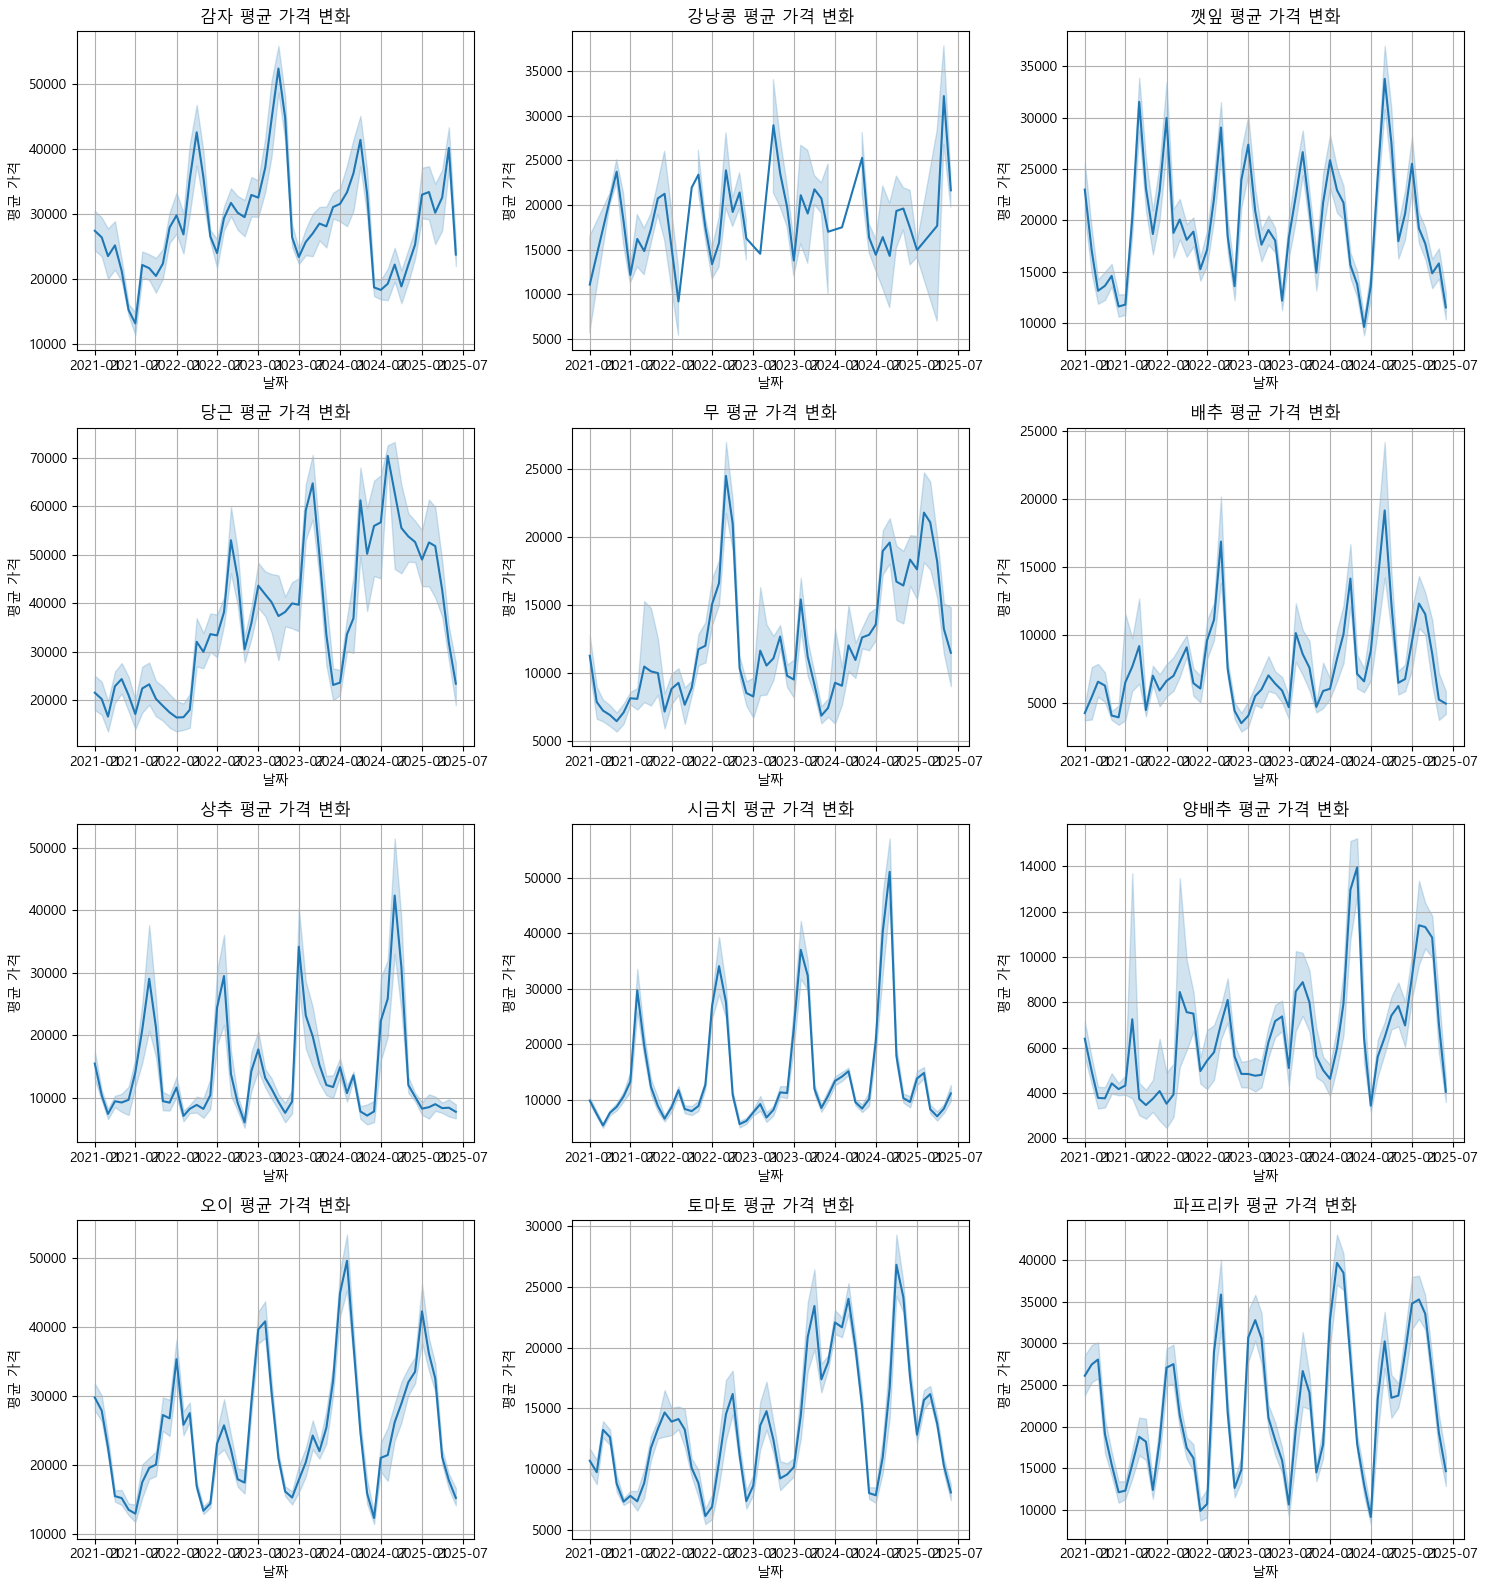

In [ ]:
# 날짜를 datetime 형식으로 변환
merged_df["날짜"] = merged_df["날짜"].dt.to_timestamp()

# 평균가격 숫자형 확인 및 변환 (안전하게 다시 한 번)
merged_df["평균가격"] = pd.to_numeric(merged_df["평균가격"], errors="coerce")

# 그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns

unique_items = merged_df["품목"].unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    item_df = merged_df[merged_df["품목"] == item]
    sns.lineplot(data=item_df, x="날짜", y="평균가격", ax=axes[i])
    axes[i].set_title(f"{item} 평균 가격 변화")
    axes[i].set_xlabel("날짜")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

# 남은 빈 그래프 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 7. 날씨 데이터 시각화 (품목별 Subplot)

### 7.1. 평균 기온과 평균 가격의 관계 (산점도 및 비선형 회귀)

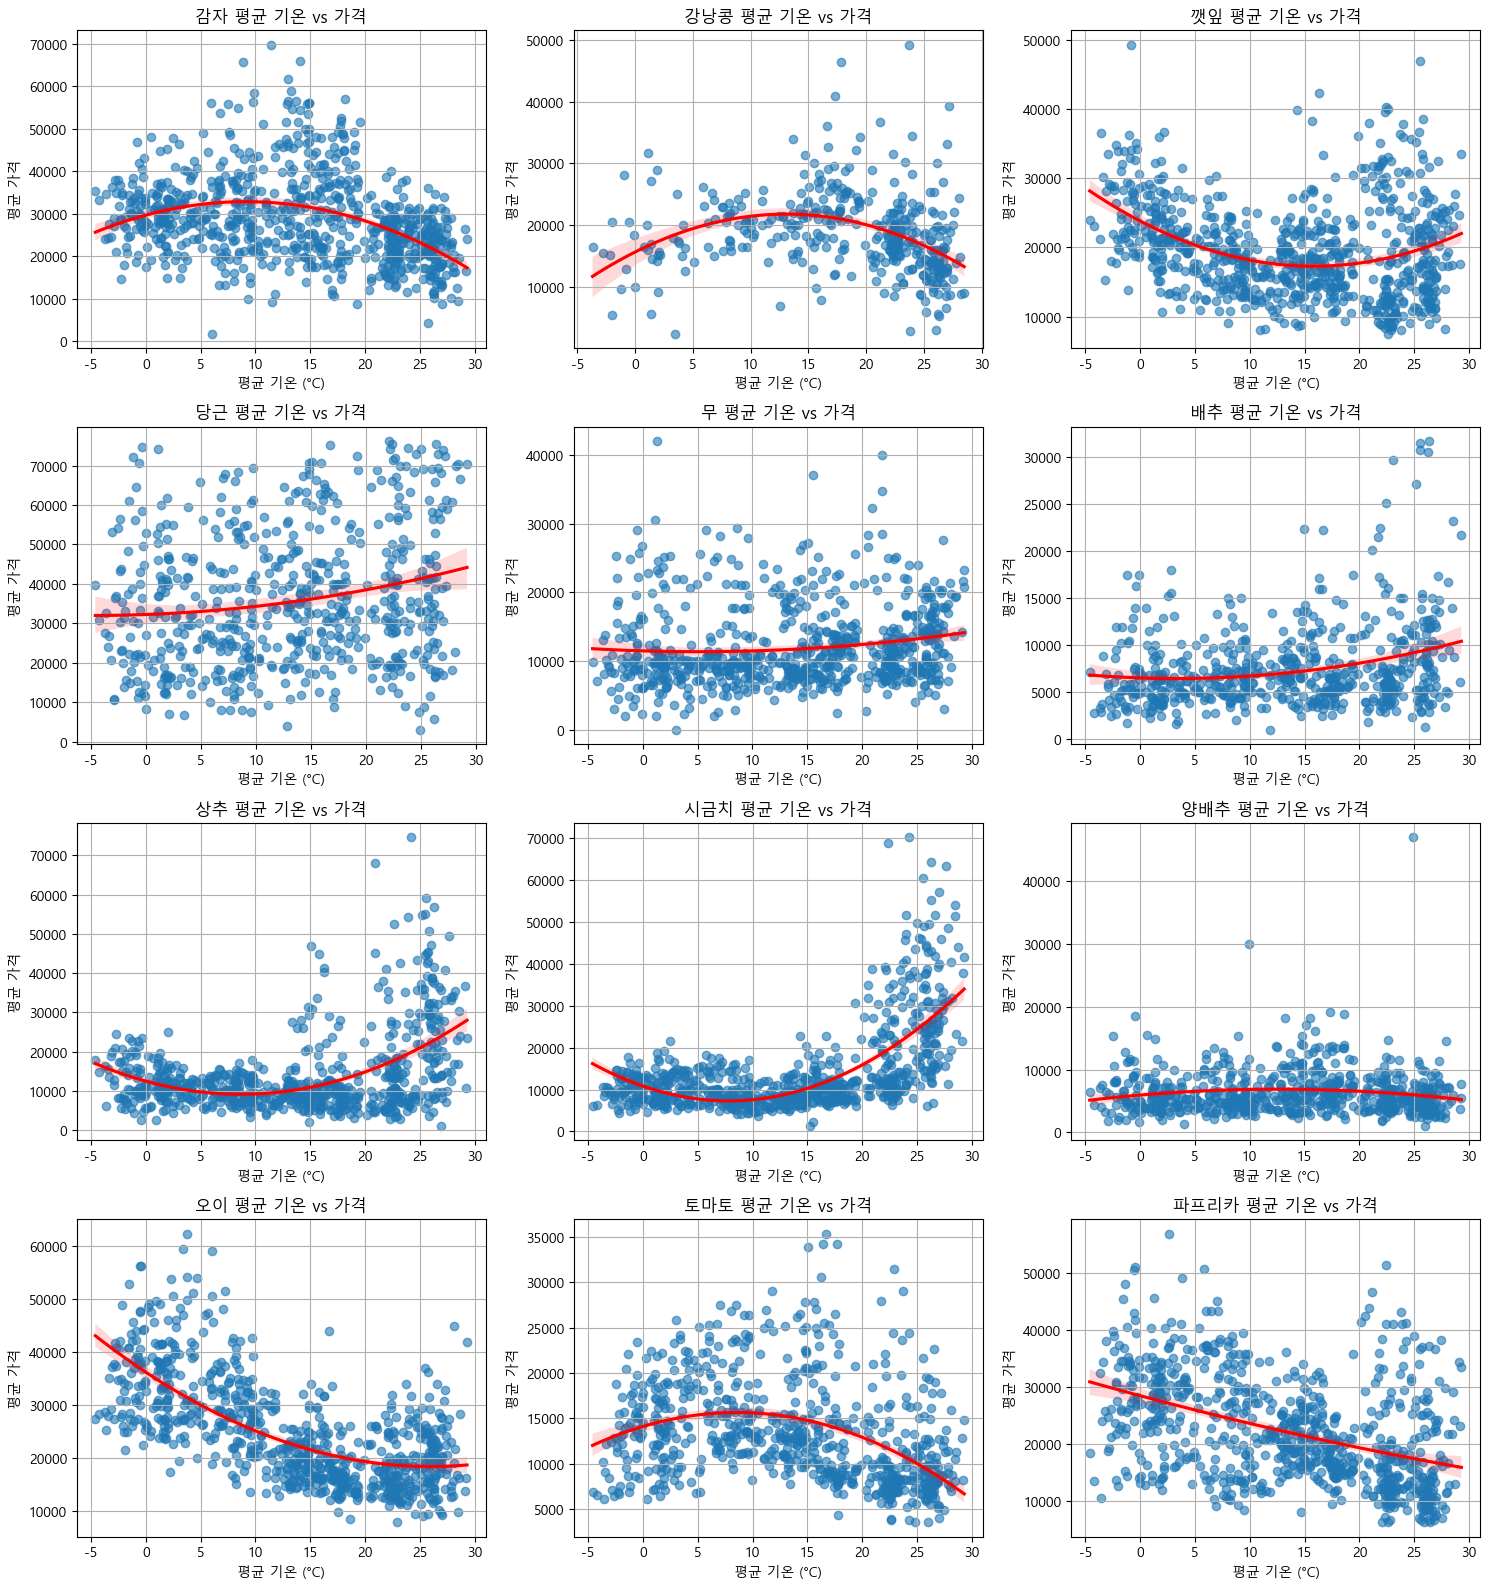

In [ ]:
unique_items = merged_df["품목"] .unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    sns.regplot(data=merged_df[merged_df["품목"] == item], x="평균기온(°C)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[i])
    axes[i].set_title(f"{item} 평균 기온 vs 가격")
    axes[i].set_xlabel("평균 기온 (°C)")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 7.2. 월합 강수량과 평균 가격의 관계 (산점도 및 비선형 회귀)

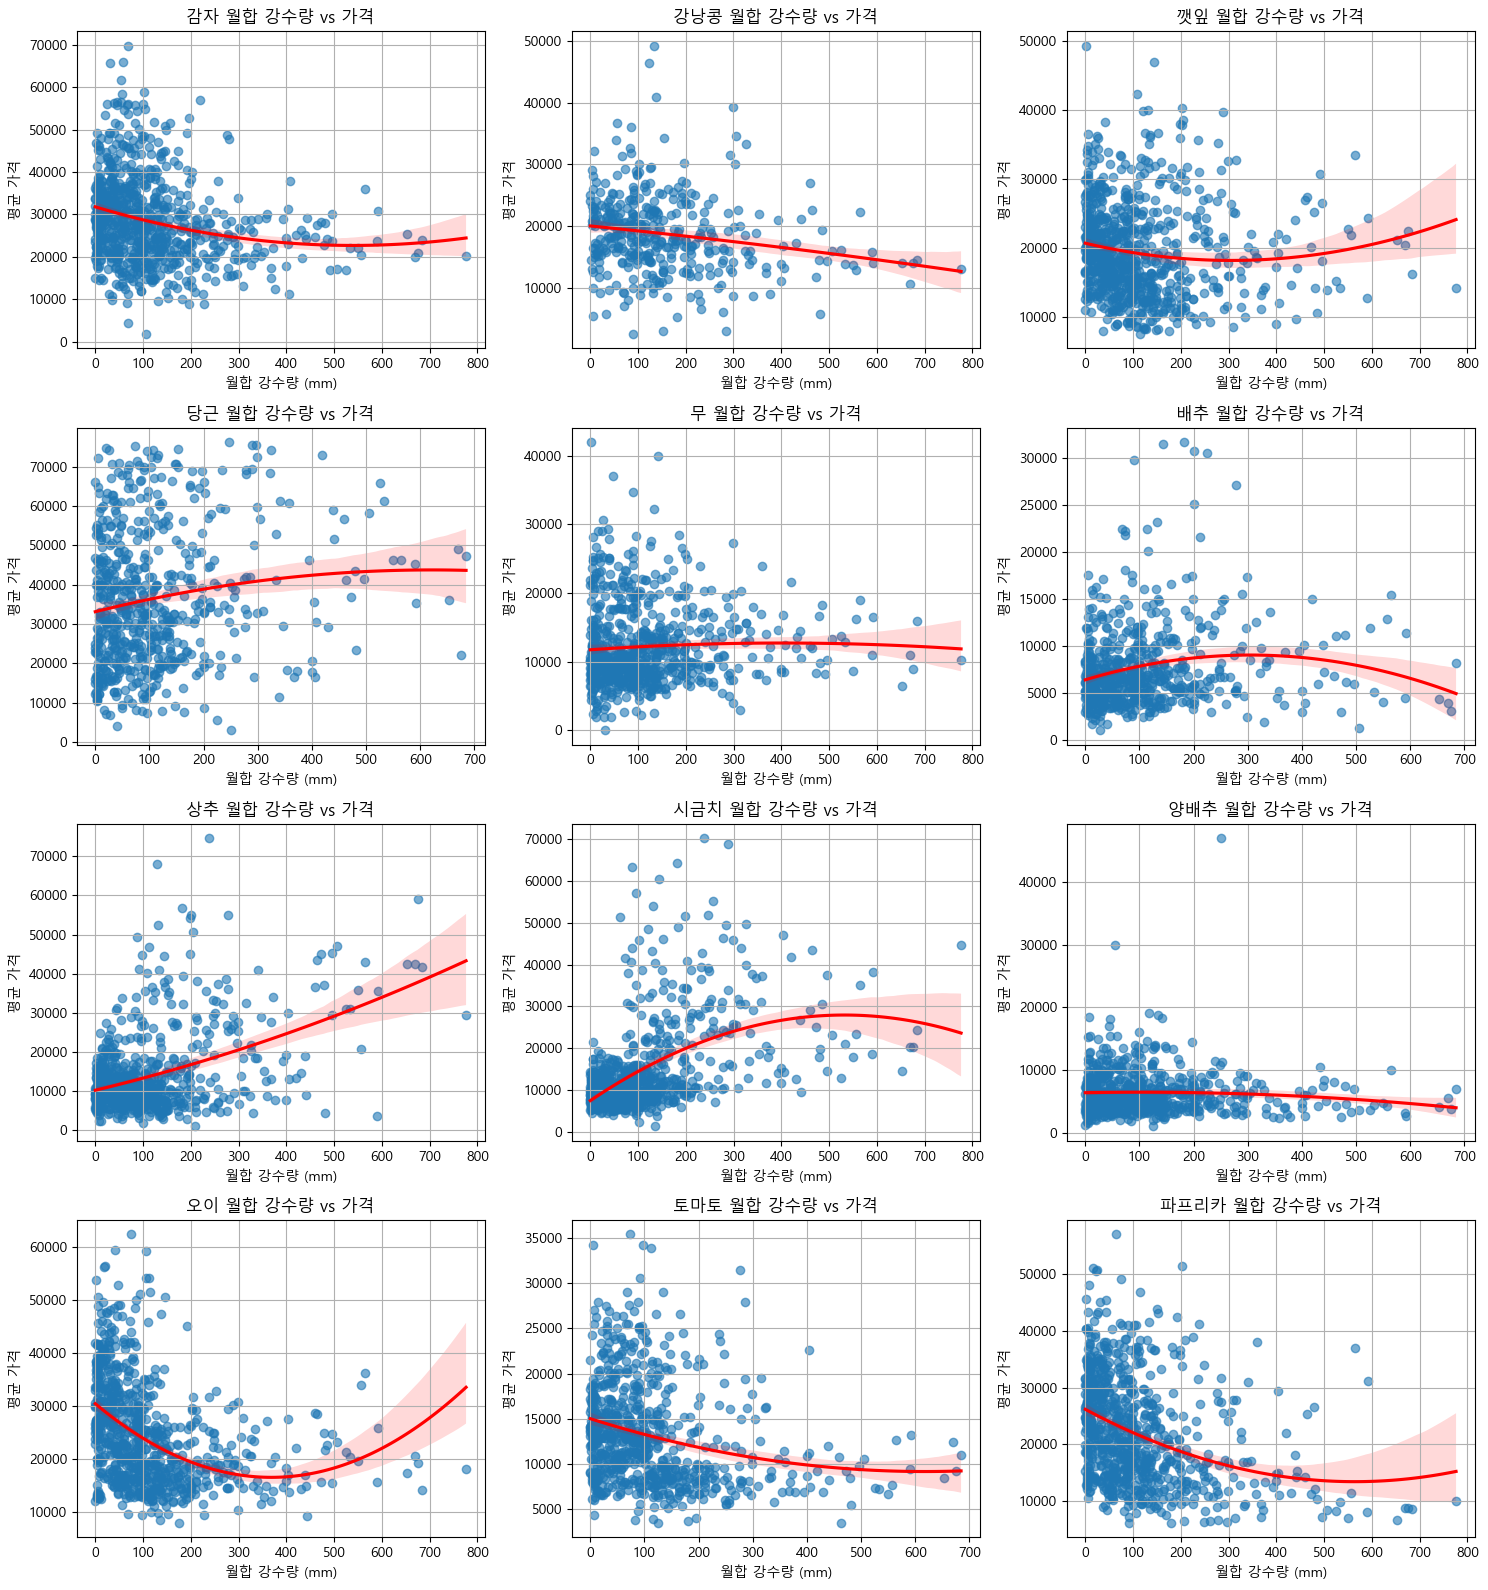

In [ ]:
unique_items = merged_df["품목"] .unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    sns.regplot(data=merged_df[merged_df["품목"] == item], x="월합강수량(00~24h만)(mm)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[i])
    axes[i].set_title(f"{item} 월합 강수량 vs 가격")
    axes[i].set_xlabel("월합 강수량 (mm)")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 8. 품목별 날씨-가격 상관관계 분석 및 주요 품목 시각화 (Subplot)


--- 날씨 변수와 상관관계가 높은 상위 품목: ['오이', '시금치', '파프리카'] ---



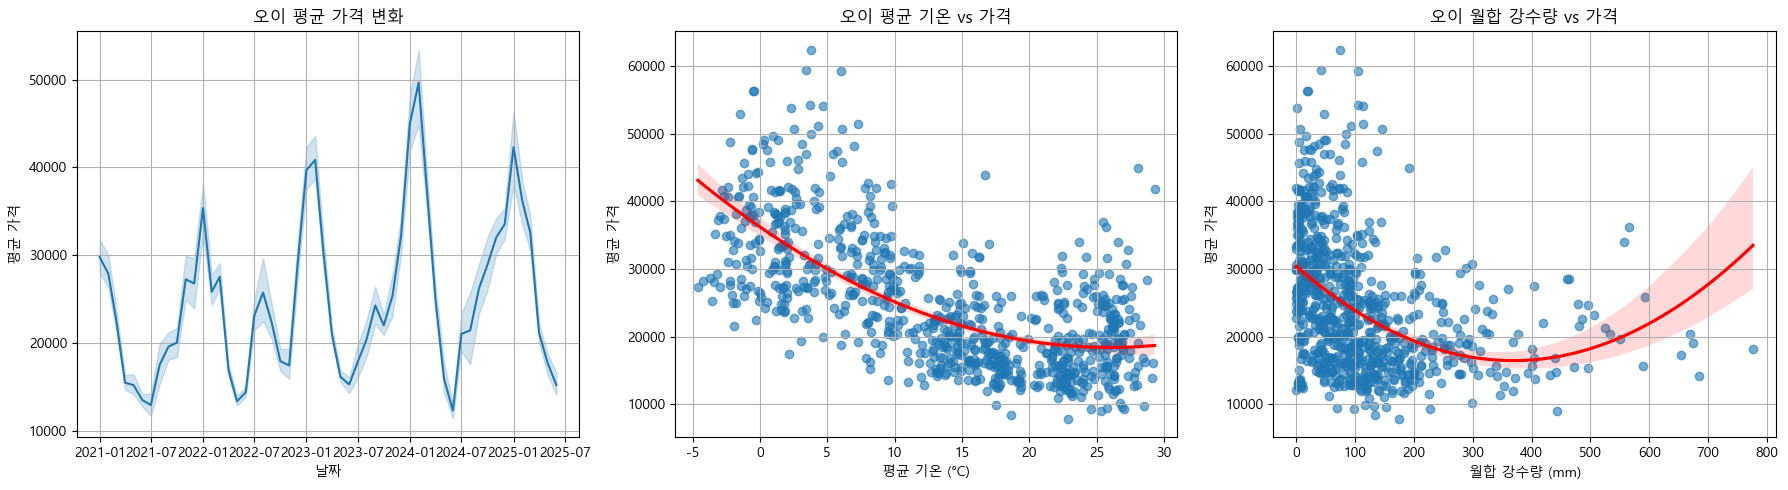

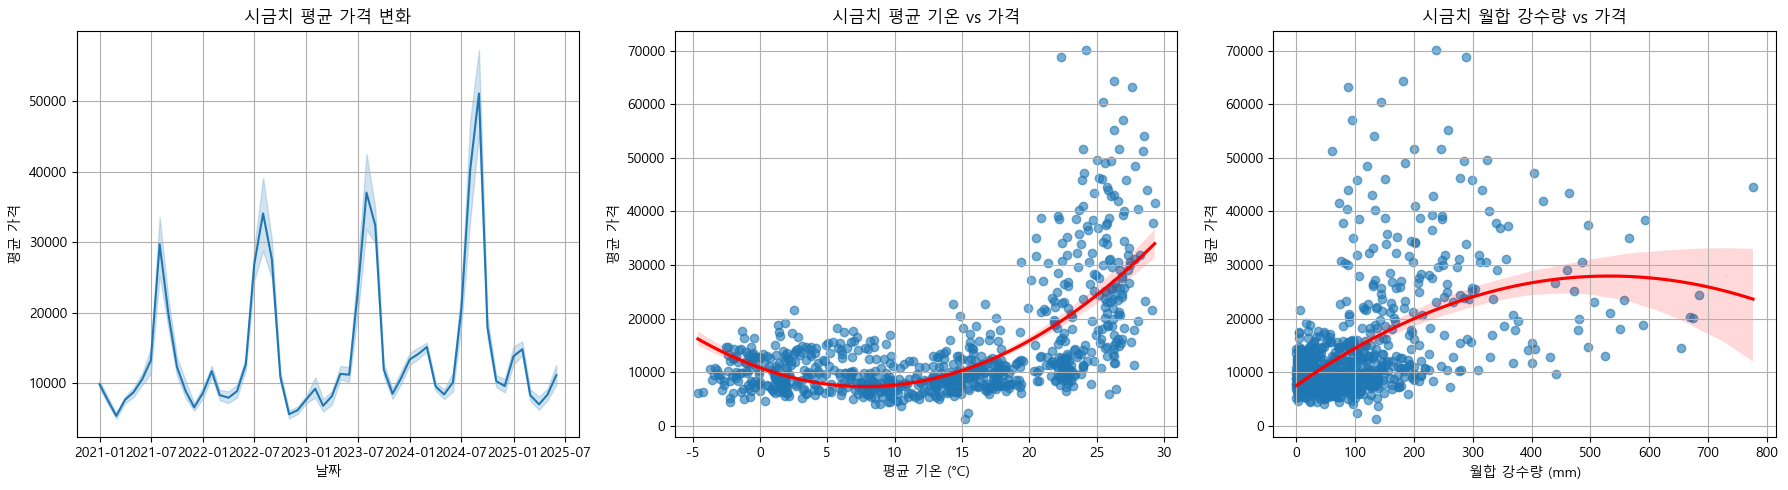

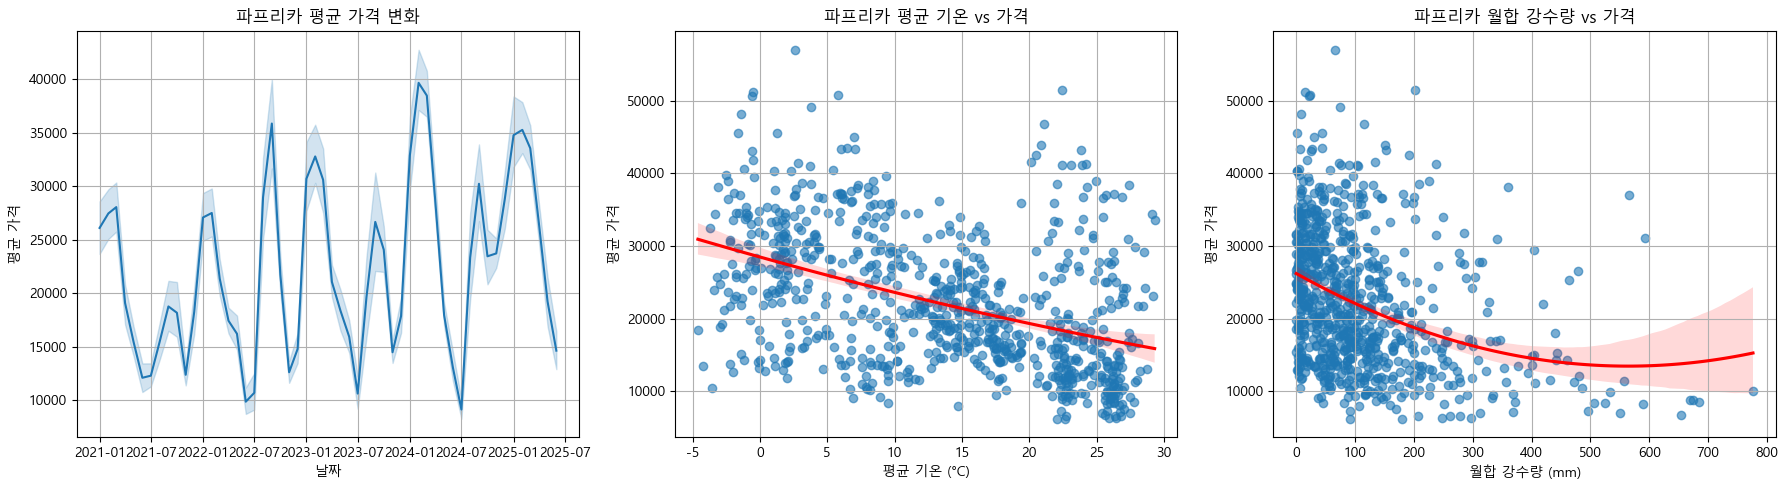

In [ ]:
# 각 품목별로 날씨 변수와 평균가격 간의 상관관계 계산
weather_vars = ["평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
item_correlations = {}

for item in merged_df["품목"] .unique():
    item_df = merged_df[merged_df["품목"] == item].copy()
    if not item_df.empty and "평균가격" in item_df.columns:
        corrs = item_df[weather_vars + ["평균가격"]] .corr()
        if "평균가격" in corrs.columns:
            valid_corrs = corrs["평균가격"][:-1].dropna()
            if not valid_corrs.empty:
                item_correlations[item] = valid_corrs.abs() .max()

filtered_items = {k: v for k, v in item_correlations.items() if pd.notna(v)}
sorted_items = sorted(filtered_items.items(), key=lambda x: x[1], reverse=True)
top_items = [item for item, corr in sorted_items[:3]]

print(f"\n--- 날씨 변수와 상관관계가 높은 상위 품목: {top_items} ---\n")

for item in top_items:
    item_df = merged_df[merged_df["품목"] == item].copy()
    if item_df.empty:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.lineplot(data=item_df, x="날짜", y="평균가격", ax=axes[0])
    axes[0].set_title(f"{item} 평균 가격 변화")
    axes[0].set_xlabel("날짜")
    axes[0].set_ylabel("평균 가격")
    axes[0].grid(True)

    sns.regplot(data=item_df, x="평균기온(°C)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[1])
    axes[1].set_title(f"{item} 평균 기온 vs 가격")
    axes[1].set_xlabel("평균 기온 (°C)")
    axes[1].set_ylabel("평균 가격")
    axes[1].grid(True)

    sns.regplot(data=item_df, x="월합강수량(00~24h만)(mm)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[2])
    axes[2].set_title(f"{item} 월합 강수량 vs 가격")
    axes[2].set_xlabel("월합 강수량 (mm)")
    axes[2].set_ylabel("평균 가격")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()